In [1]:
import random
import re

import pandas as pd
import pytorch_lightning as pl

from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from freestyl.dataset.dataframe_wrapper import DataframeWrapper
from freestyl.supervised.siamese import train_dataframewrappers, get_df_prediction
from freestyl.supervised.siamese.utils import score_from_preds, find_index_of_first_change
from freestyl.supervised.siamese.features.model import SiameseFeatureModule
from freestyl.utils import plot_aucroc_curve
#>>> x = [1, 2, 3, 4, 5, 6]
#>>> .shuffle(x)

NEW_DATASET = False
SPLIT_ON_AUTHORS = False
USE_POS = True
USE_TRIG = True
USE_FW = True
LR = 1e-4
BATCH = 64
DROPOUT = .3
LOSS = "stn_contrastive"
CHRYSOSTOM = True
SAMPLE = True
COMMENT = False
DEV_MINER = True
SPLIT = False
ISDIST = "linear" not in LOSS
METRICKEY = "Probability" if not ISDIST else "Distance"

if SPLIT:
    SIZE = (32, 32, 32)
elif USE_POS and not USE_FW:
    SIZE = 50
elif USE_POS and USE_FW:
    SIZE = 64
else:
    SIZE = 64
    
seed = 42
REMOVED = ["Euclides"]


def make_file_name(filename: str) -> str:
    return filename

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in 

## Import Data

In [2]:
train = pd.read_csv("tlg-train.csv")
dev = pd.read_csv("tlg-dev.csv")
test = pd.read_csv("tlg-test.csv")
    
train = train[~train.author.isin(REMOVED)]
dev = dev[~dev.author.isin(REMOVED)]
test = test[~test.author.isin(REMOVED)]

if not CHRYSOSTOM:
    train = train[~train.author.str.contains("Chrysosto")]
    dev = dev[~dev.author.str.contains("Chrysosto")]
    test = test[~test.author.str.contains("Chrysosto")]
    
if not COMMENT:
    train = train[~train.title.str.contains("Comment")]
    dev = dev[~dev.title.str.contains("Comment")]
    test = test[~test.title.str.contains("Comment")]

print(f"Train Shape : {train.shape}")
print(f"Dev Shape : {dev.shape}")
print(f"Test Shape : {test.shape}")

Train Shape : (1681, 2108)
Dev Shape : (174, 2108)
Test Shape : (216, 2107)


In [3]:
train.title.str.contains("Comment").value_counts()
test.title.str.contains("Comment").value_counts()

False    216
Name: title, dtype: int64

In [4]:
train.title.unique().shape

(496,)

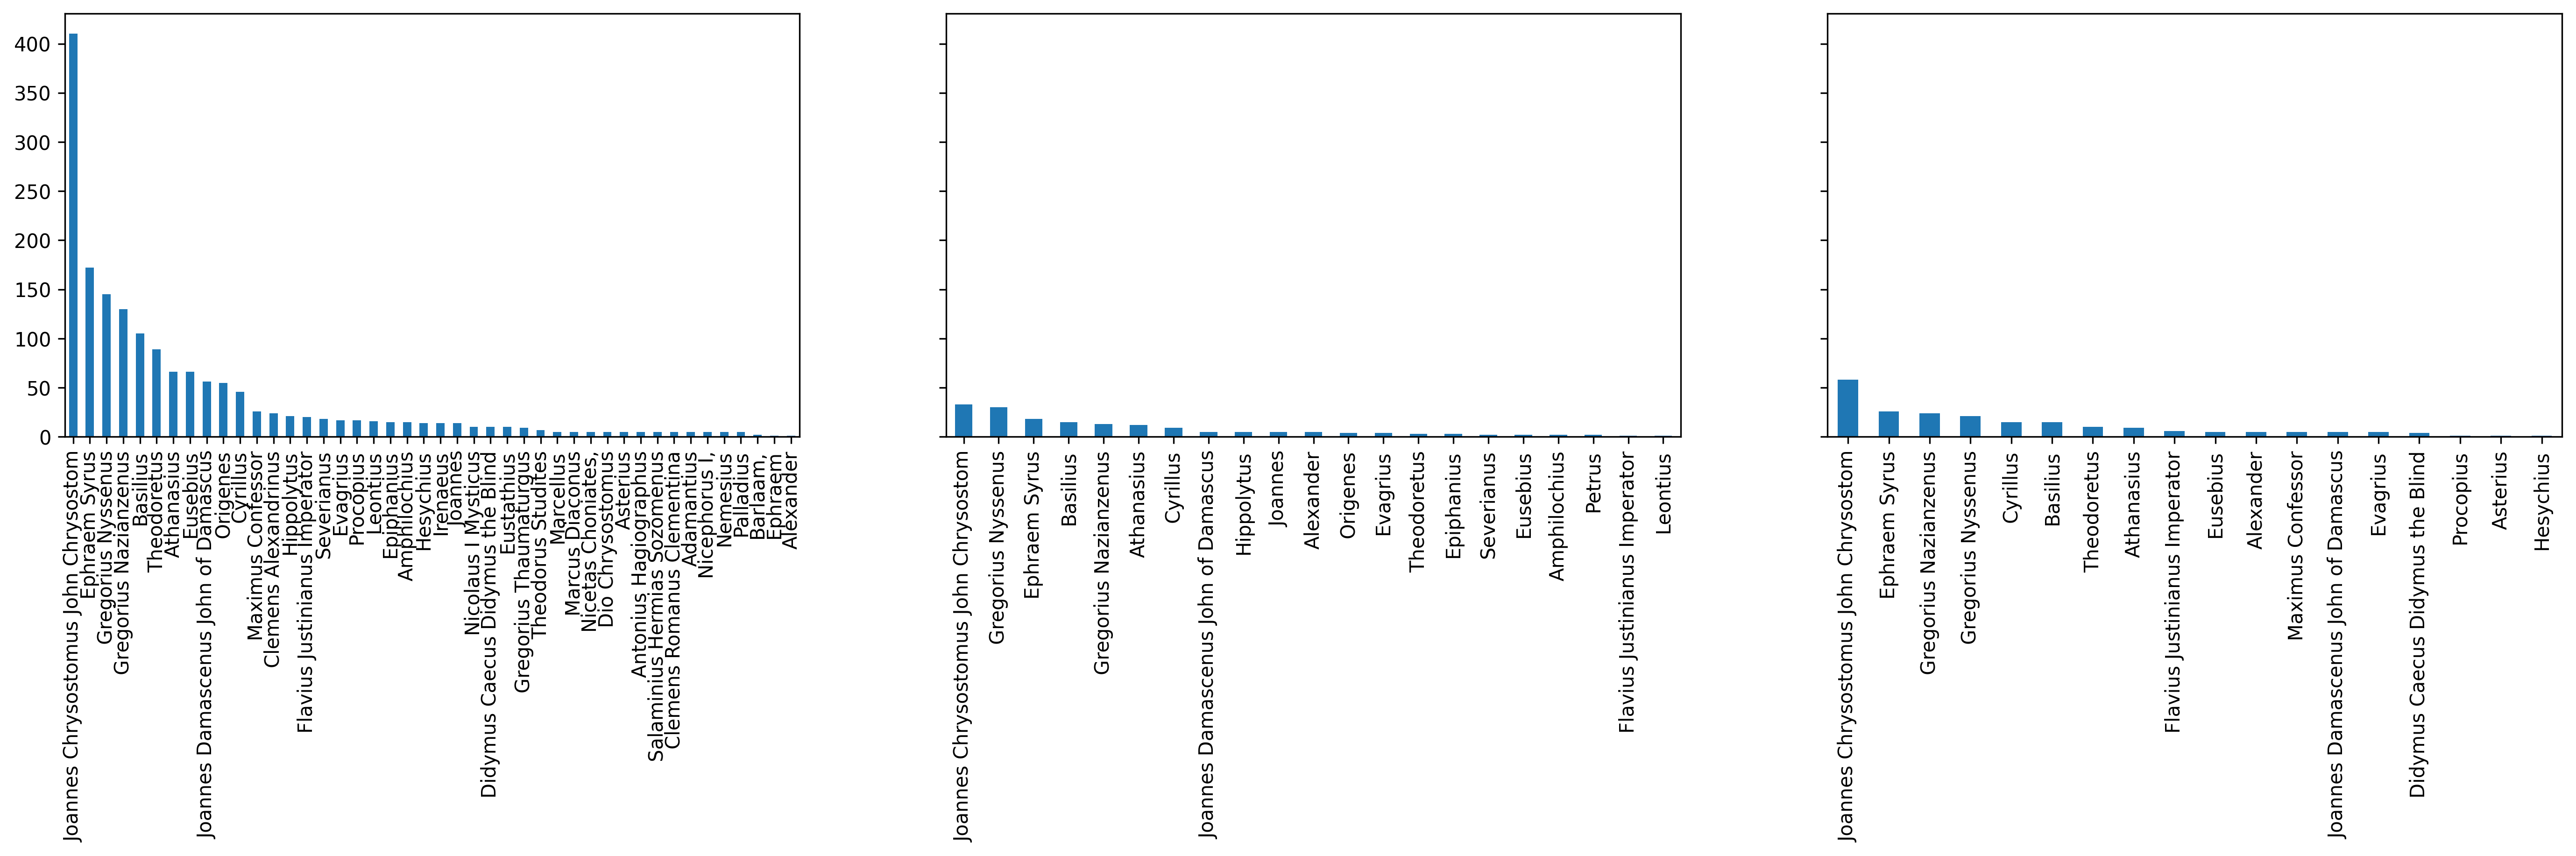

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=300, figsize = (23, 4), sharey=True)
train.author.value_counts().plot.bar(ax=ax1)
dev.author.value_counts().plot.bar(ax=ax2)
test.author.value_counts().plot.bar(ax=ax3)
fig.savefig(make_file_name("samples.png"))

## Util functions

In [6]:
def assign_normalization(dfw):
    dfw.normalized._dataframe = dfw.dataframe.fillna(0)
    
def get_scores(scores, distance: float, col=METRICKEY, noprint=False) -> None:

    if "distance" in col.lower():
        scores["Attribution"] = scores[col] <= distance
    else:
        scores["Attribution"] = scores[col] >= distance
    
    pos = scores[scores.IsAPair].Attribution.value_counts().to_dict()
    negs = scores[~scores.IsAPair].Attribution.value_counts().to_dict()
    
    tp = pos.get(True, 0)
    fn = pos.get(False, 0)
    fp = negs.get(True, 0)
    tn = negs.get(False, 0)
    
    if noprint is False:
        print(f"True positives: {tp}\nFalse Negative {fn}")
        print(f"True Negative {tn}")
        print(f"False positives: {fp}\nAccuracy: {tp/(fn+tp):.2f}")
    return tp, fp, tn, fn

## Loading the model

In [7]:
models = SiameseFeatureModule.load_from_checkpoint("./lightning_logs/version_0/checkpoints/epoch=170-step=4617.ckpt") 

models.eval()

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


SiameseFeatureModule(
  (aucroc): AUROC()
  (distance): SNRDistance()
  (loss_func): SignalToNoiseRatioContrastiveLoss(
    (distance): SNRDistance()
    (reducer): MultipleReducers(
      (reducers): ModuleDict(
        (pos_loss): AvgNonZeroReducer()
        (neg_loss): AvgNonZeroReducer()
      )
      (default_reducer): MeanReducer()
    )
  )
  (miner): BatchEasyHardMiner(
    (distance): SNRDistance()
  )
  (encoder): Sequential(
    (0): BatchNorm1d(2100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2100, out_features=64, bias=True)
  )
)

## Automatically retrieve some constant parameters

In [8]:
FEATURES = models.hparams["features"]
IGNORE = set([col for col in train.columns if col not in FEATURES])

## Get DataFrameWrapper

In [9]:
data = DataframeWrapper(train, target="author", label=["author", "title"], x_ignore=IGNORE)
assign_normalization(data)
data.update_features(FEATURES)
data_dev = DataframeWrapper(dev, target="author", label=["author", "title"], x_ignore=IGNORE)
data_dev.update_features(data.features)
assign_normalization(data_dev)
data_test = DataframeWrapper(test, target="author", label=["author", "title"], x_ignore=IGNORE)
data_test.update_features(data.features)
assign_normalization(data_test)
data._x_ignore

('file',
 'Unnamed: 0',
 'author',
 'tokens',
 'modified_text',
 'title',
 'textgroup',
 'length')

## CHecking some details

In [10]:
data.normalized.xs.head()

$POS$v-n-v  $POS$v-c-d  $POS$d-l-n  $POS$l-n-n  $POS$d-n-v  $POS$n-v-l  \
0    0.001786    0.010714    0.012500    0.017857    0.010714    0.017857   
2    0.001980    0.007921    0.009901    0.013861    0.009901    0.027723   
3    0.002519    0.005038    0.015113    0.015113    0.002519    0.022670   
5    0.007018    0.001754    0.010526    0.021053    0.001754    0.024561   
6    0.000000    0.003992    0.007984    0.021956    0.000000    0.017964   

   $POS$l-l-n  $POS$n-n-v  $POS$n-v-n  $POS$n-v-r  ...  $TRI$σῶμ  $TRI$οἷο  \
0    0.008929    0.008929    0.003571    0.014286  ...  0.000268  0.000000   
2    0.013861    0.011881    0.015842    0.001980  ...  0.000000  0.000000   
3    0.005038    0.002519    0.007557    0.000000  ...  0.000000  0.000279   
5    0.001754    0.012281    0.001754    0.010526  ...  0.000279  0.000000   
6    0.009980    0.013972    0.003992    0.011976  ...  0.000000  0.000000   

   $TRI$λῳ_  $TRI$_ἤγ  $TRI$ἁπλ  $TRI$_λύ  $TRI$ἐνδ  $TRI$_λυ  $TRI$λεγ  \
0  0.000268  0.000000  0.000268  0.000268  0.000268  0.000000  0.000000   
2  0.000000  0.000000  0.000268  0.000268  0.000000  0.000000  0.000000   
3  0.000279  0.000000  0.000279  0.000000  0.000279  0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000558  0.001116   
6  0.000000  0.000278  0.000000  0.000000  0.000000  0.000000  0.000555   

   $TRI$εἴρ  
0  0.000000  
2  0.000268  
3  0.000000  
5  0.000000  
6  0.000000  

[5 rows x 2100 columns]

### Get first FP distance

In [11]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
scores = get_df_prediction(trainer, model=models, compared=data)
#scores
print(f"ROC: {roc_auc_score(scores.IsAPair, scores.Probability)}")

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ROC: 0.969089092494092


In [12]:
scores[~scores.IsAPair].sort_values("Distance").head()

ComparedClass                         ComparedLabel  \
32913              Origenes     Origenes - Homiliae in Ezechielem   
1591918         Theodoretus  Theodoretus - Historia ecclesiastica   
32886              Origenes     Origenes - Homiliae in Ezechielem   
1444953         Theodoretus  Theodoretus - Historia ecclesiastica   
232758   Gregorius Nyssenus        Gregorius Nyssenus - Epistulae   

        ComparatorClass                       ComparatorLabel  Distance  \
32913       Theodoretus  Theodoretus - Historia ecclesiastica  0.435744   
1591918        Origenes          Origenes - Homiliae in Lucam  0.489853   
32886       Theodoretus  Theodoretus - Historia ecclesiastica  0.518521   
1444953        Origenes     Origenes - Homiliae in Ezechielem  0.519624   
232758         Basilius        Basilius - In Gordium martyrem  0.522184   

         Probability  Attribution  IsAPair  K  
32913       0.564256         True    False  0  
1591918     0.510147         True    False  0  
32886       0.481479        False    False  0  
1444953     0.480376        False    False  0  
232758      0.477816        False    False  0

## Evaluating Dev for Test Threshold

In [14]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
dev_pairs = get_df_prediction(trainer, model=models, compared=data_dev)
#scores
print(f"ROC: {roc_auc_score(dev_pairs.IsAPair, dev_pairs.Probability)}")

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ROC: 0.8698833881710994


In [15]:
dev_pairs[~dev_pairs.IsAPair].sort_values("Distance").head()

ComparedClass                                      ComparedLabel  \
27075  Gregorius Nyssenus         Gregorius Nyssenus - Vita sanctae Macrinae   
27086  Gregorius Nyssenus  Gregorius Nyssenus - De deitate adversus Evagr...   
12024            Basilius                  Basilius - Homiliae in hexaemeron   
5792   Gregorius Nyssenus         Gregorius Nyssenus - Vita sanctae Macrinae   
27074  Gregorius Nyssenus      Gregorius Nyssenus - Oratio catechetica magna   

          ComparatorClass                             ComparatorLabel  \
27075            Basilius           Basilius - Homiliae in hexaemeron   
27086            Basilius           Basilius - Homiliae in hexaemeron   
12024  Gregorius Nyssenus  Gregorius Nyssenus - Vita sanctae Macrinae   
5792             Basilius           Basilius - Homiliae in hexaemeron   
27074            Basilius           Basilius - Homiliae in hexaemeron   

       Distance  Probability  Attribution  IsAPair  K  
27075  0.396463     0.603537         True    False  0  
27086  0.508997     0.491003        False    False  0  
12024  0.513670     0.486330        False    False  0  
5792   0.539876     0.460124        False    False  0  
27074  0.542246     0.457754        False    False  0

<AxesSubplot:>

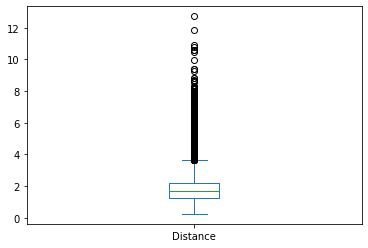

In [16]:
dev_pairs.Distance.plot.box()

In [17]:
#clip = scores.Distance.apply(lambda x: 2 if x > 2 else x)
#scores.Distance = clip

## Study AUCROC

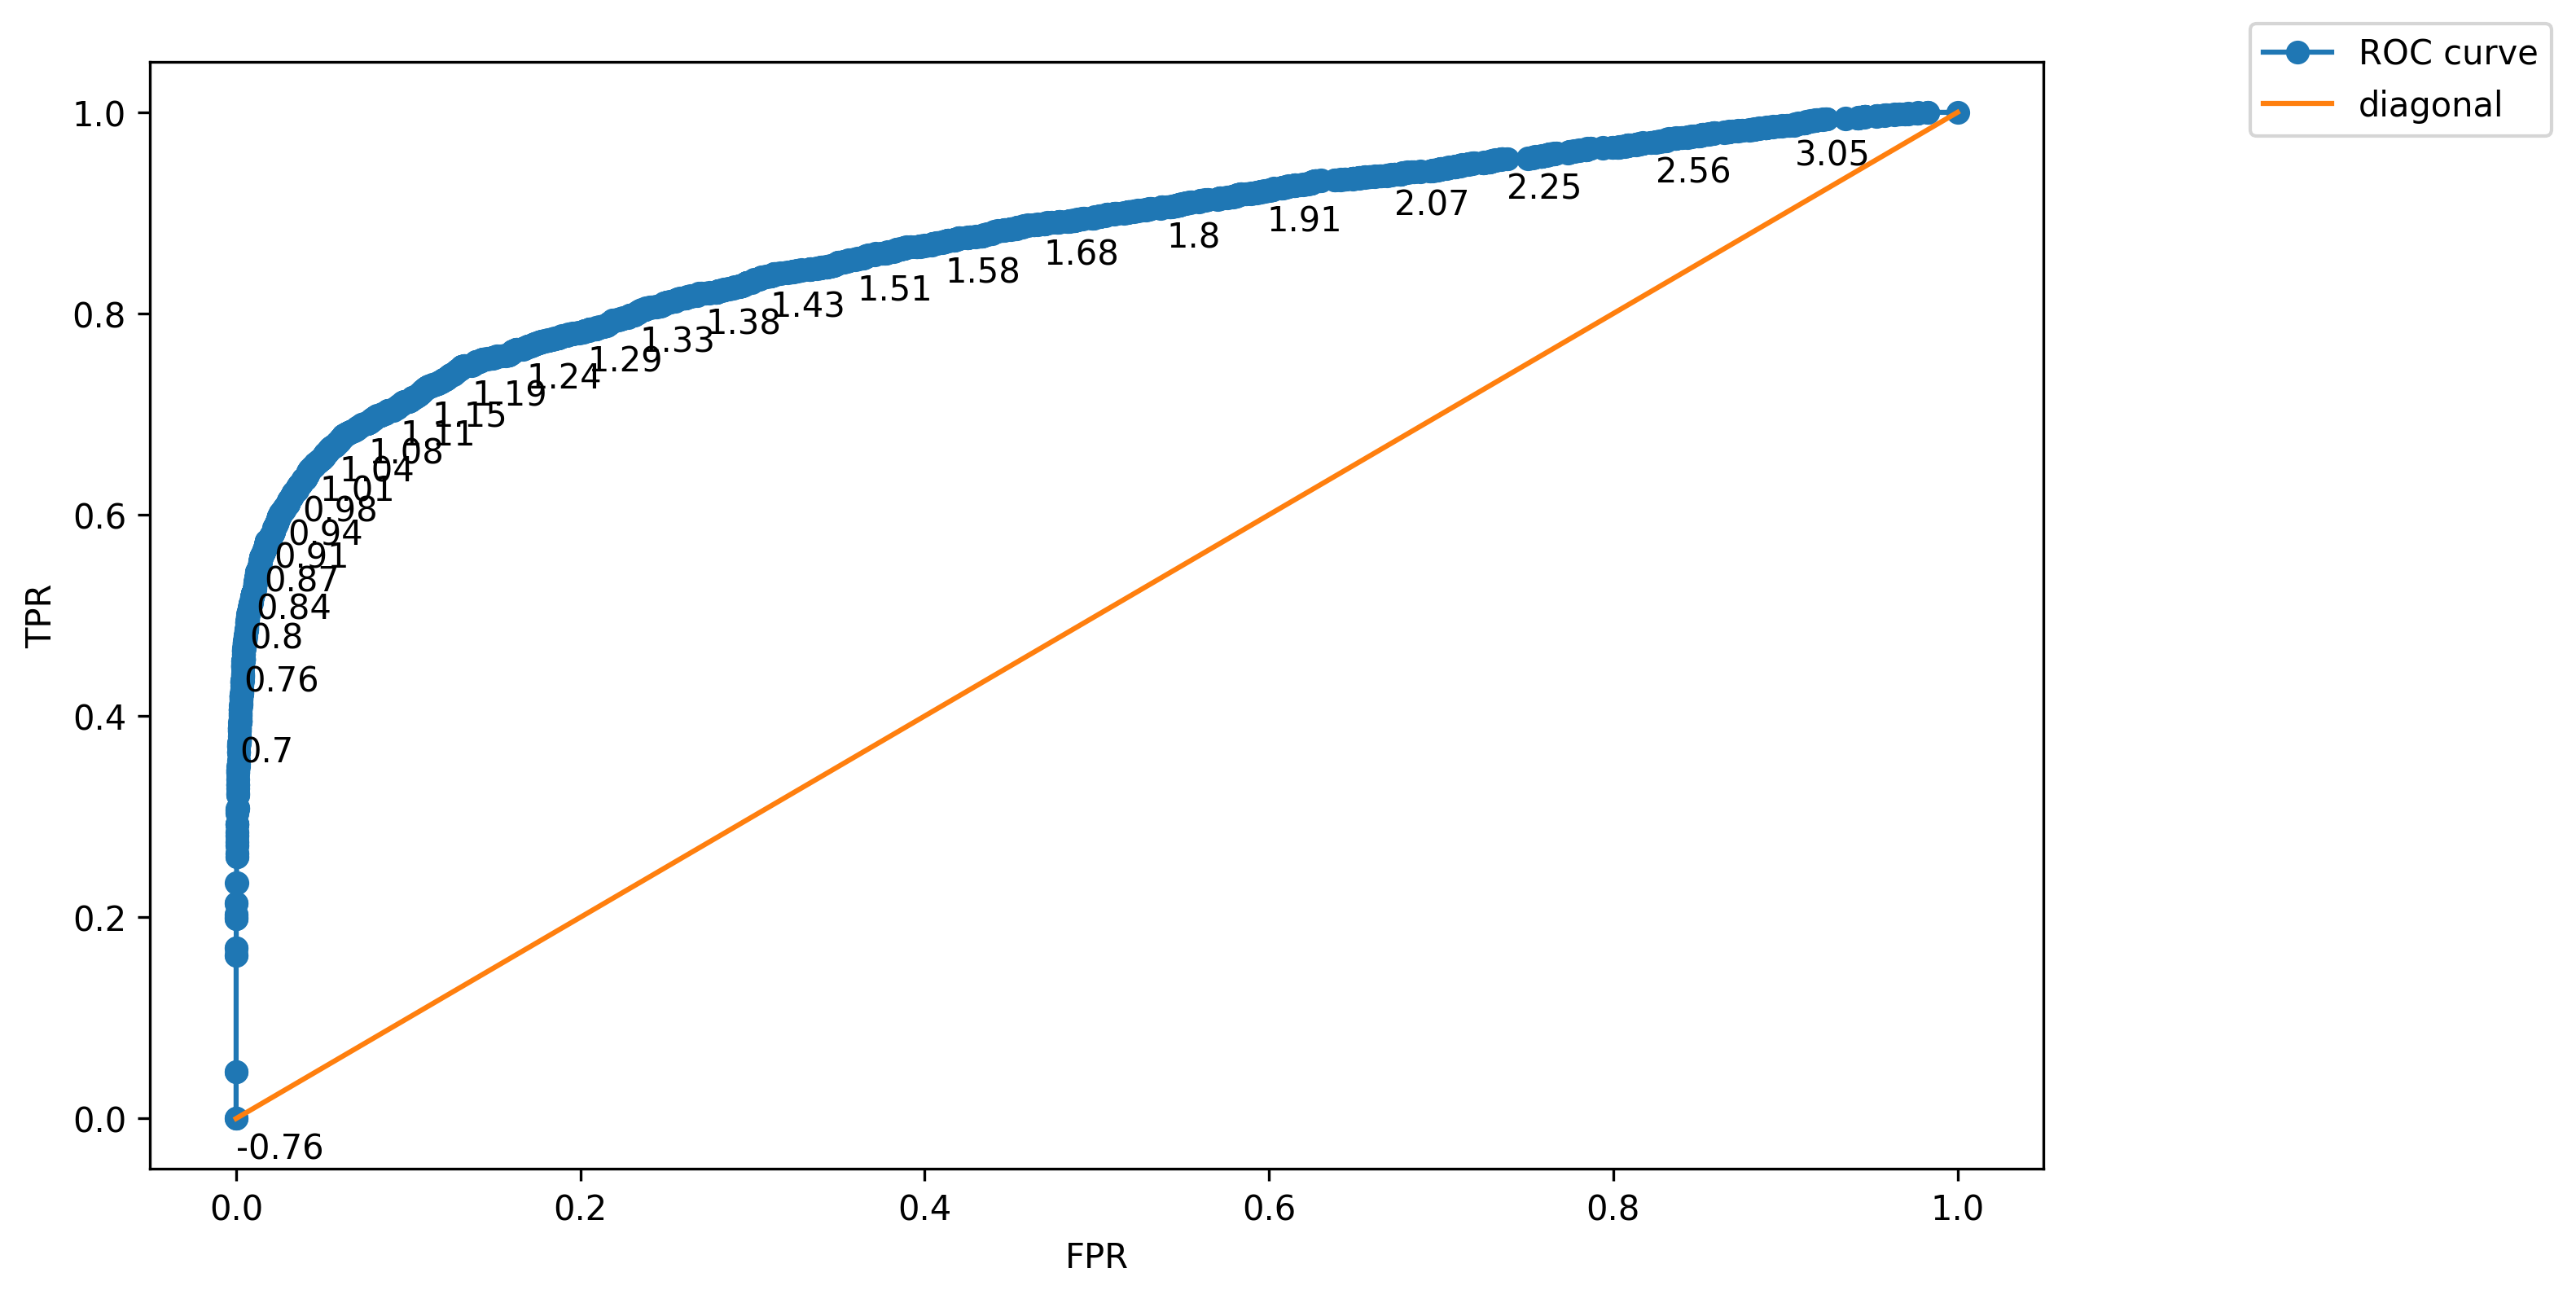

In [18]:
plot_aucroc_curve(dev_pairs.IsAPair, dev_pairs[METRICKEY], nth=100, is_dist=ISDIST)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.gcf().savefig(make_file_name("aucroc-dev.png"))

In [19]:
# for cls in dev_pairs.ComparedClass.unique():
#     plt.figure()
#     sns.boxplot(data=dev_pairs[(dev_pairs.ComparedClass==cls)], x="IsAPair", y=METRICKEY)
#     plt.gca().set_title(cls)
#     plt.gcf().savefig(make_file_name(f"Dev-{cls}.png"))
    #scores.groupby("ComparedClass").plot.box(y="Distance", x="IsAPair")

### Find sweet spot

In [20]:
MAX_DISTANCE = 6
get_scores(dev_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(dev_pairs[(dev_pairs.ComparedLabel != dev_pairs.ComparatorLabel)], MAX_DISTANCE)

True positives: 2926
False Negative 0
True Negative 111
False positives: 27065
Accuracy: 1.00

===
Without sampling
===

True positives: 2446
False Negative 0
True Negative 111
False positives: 27065
Accuracy: 1.00


/tmp/ipykernel_25462/4096291782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["Attribution"] = scores[col] <= distance


(2446, 27065, 111, 0)

## Evaluating Test with Dev Threshold

In [21]:
models.eval()
MAX_DISTANCE = 6

test_pairs = get_df_prediction(trainer, model=models, compared=data_test, threshold=MAX_DISTANCE)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [22]:
test_pairs[~test_pairs.IsAPair].sort_values(METRICKEY).head()

ComparedClass  \
18848         Flavius Justinianus Imperator   
2129                     Gregorius Nyssenus   
30309                    Gregorius Nyssenus   
15888  Joannes Chrysostomus John Chrysostom   
43918  Joannes Chrysostomus John Chrysostom   

                                           ComparedLabel ComparatorClass  \
18848  Flavius Justinianus Imperator - Contra monophy...      Athanasius   
2129                Gregorius Nyssenus - Contra Eunomium        Basilius   
30309               Gregorius Nyssenus - Contra Eunomium        Basilius   
15888  Joannes Chrysostomus John Chrysostom - In epis...      Athanasius   
43918  Joannes Chrysostomus John Chrysostom - De cons...      Athanasius   

                                         ComparatorLabel  Distance  \
18848  Athanasius - De synodis Arimini in Italia et S...  0.526040   
2129              Basilius - Adversus Eunomium (libri 5)  0.542402   
30309             Basilius - Adversus Eunomium (libri 5)  0.555069   
15888  Athanasius - In illud: Qui dixerit verbum in f...  0.558307   
43918  Athanasius - In illud: Qui dixerit verbum in f...  0.566385   

       Probability  Attribution  IsAPair  K  
18848     0.473960         True    False  0  
2129      0.457598         True    False  0  
30309     0.444931         True    False  0  
15888     0.441693         True    False  0  
43918     0.433615         True    False  0

In [23]:
print(f"ROC: {roc_auc_score(test_pairs.IsAPair, test_pairs.Probability)}")
MAX_DISTANCE = 6
get_scores(test_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(test_pairs[(test_pairs.ComparedLabel != test_pairs.ComparatorLabel)], MAX_DISTANCE)

ROC: 0.9240299998382882
True positives: 5652
False Negative 0
True Negative 93
False positives: 40695
Accuracy: 1.00

===
Without sampling
===

True positives: 4932
False Negative 0
True Negative 93
False positives: 40695
Accuracy: 1.00


/tmp/ipykernel_25462/4096291782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["Attribution"] = scores[col] <= distance


(4932, 40695, 93, 0)

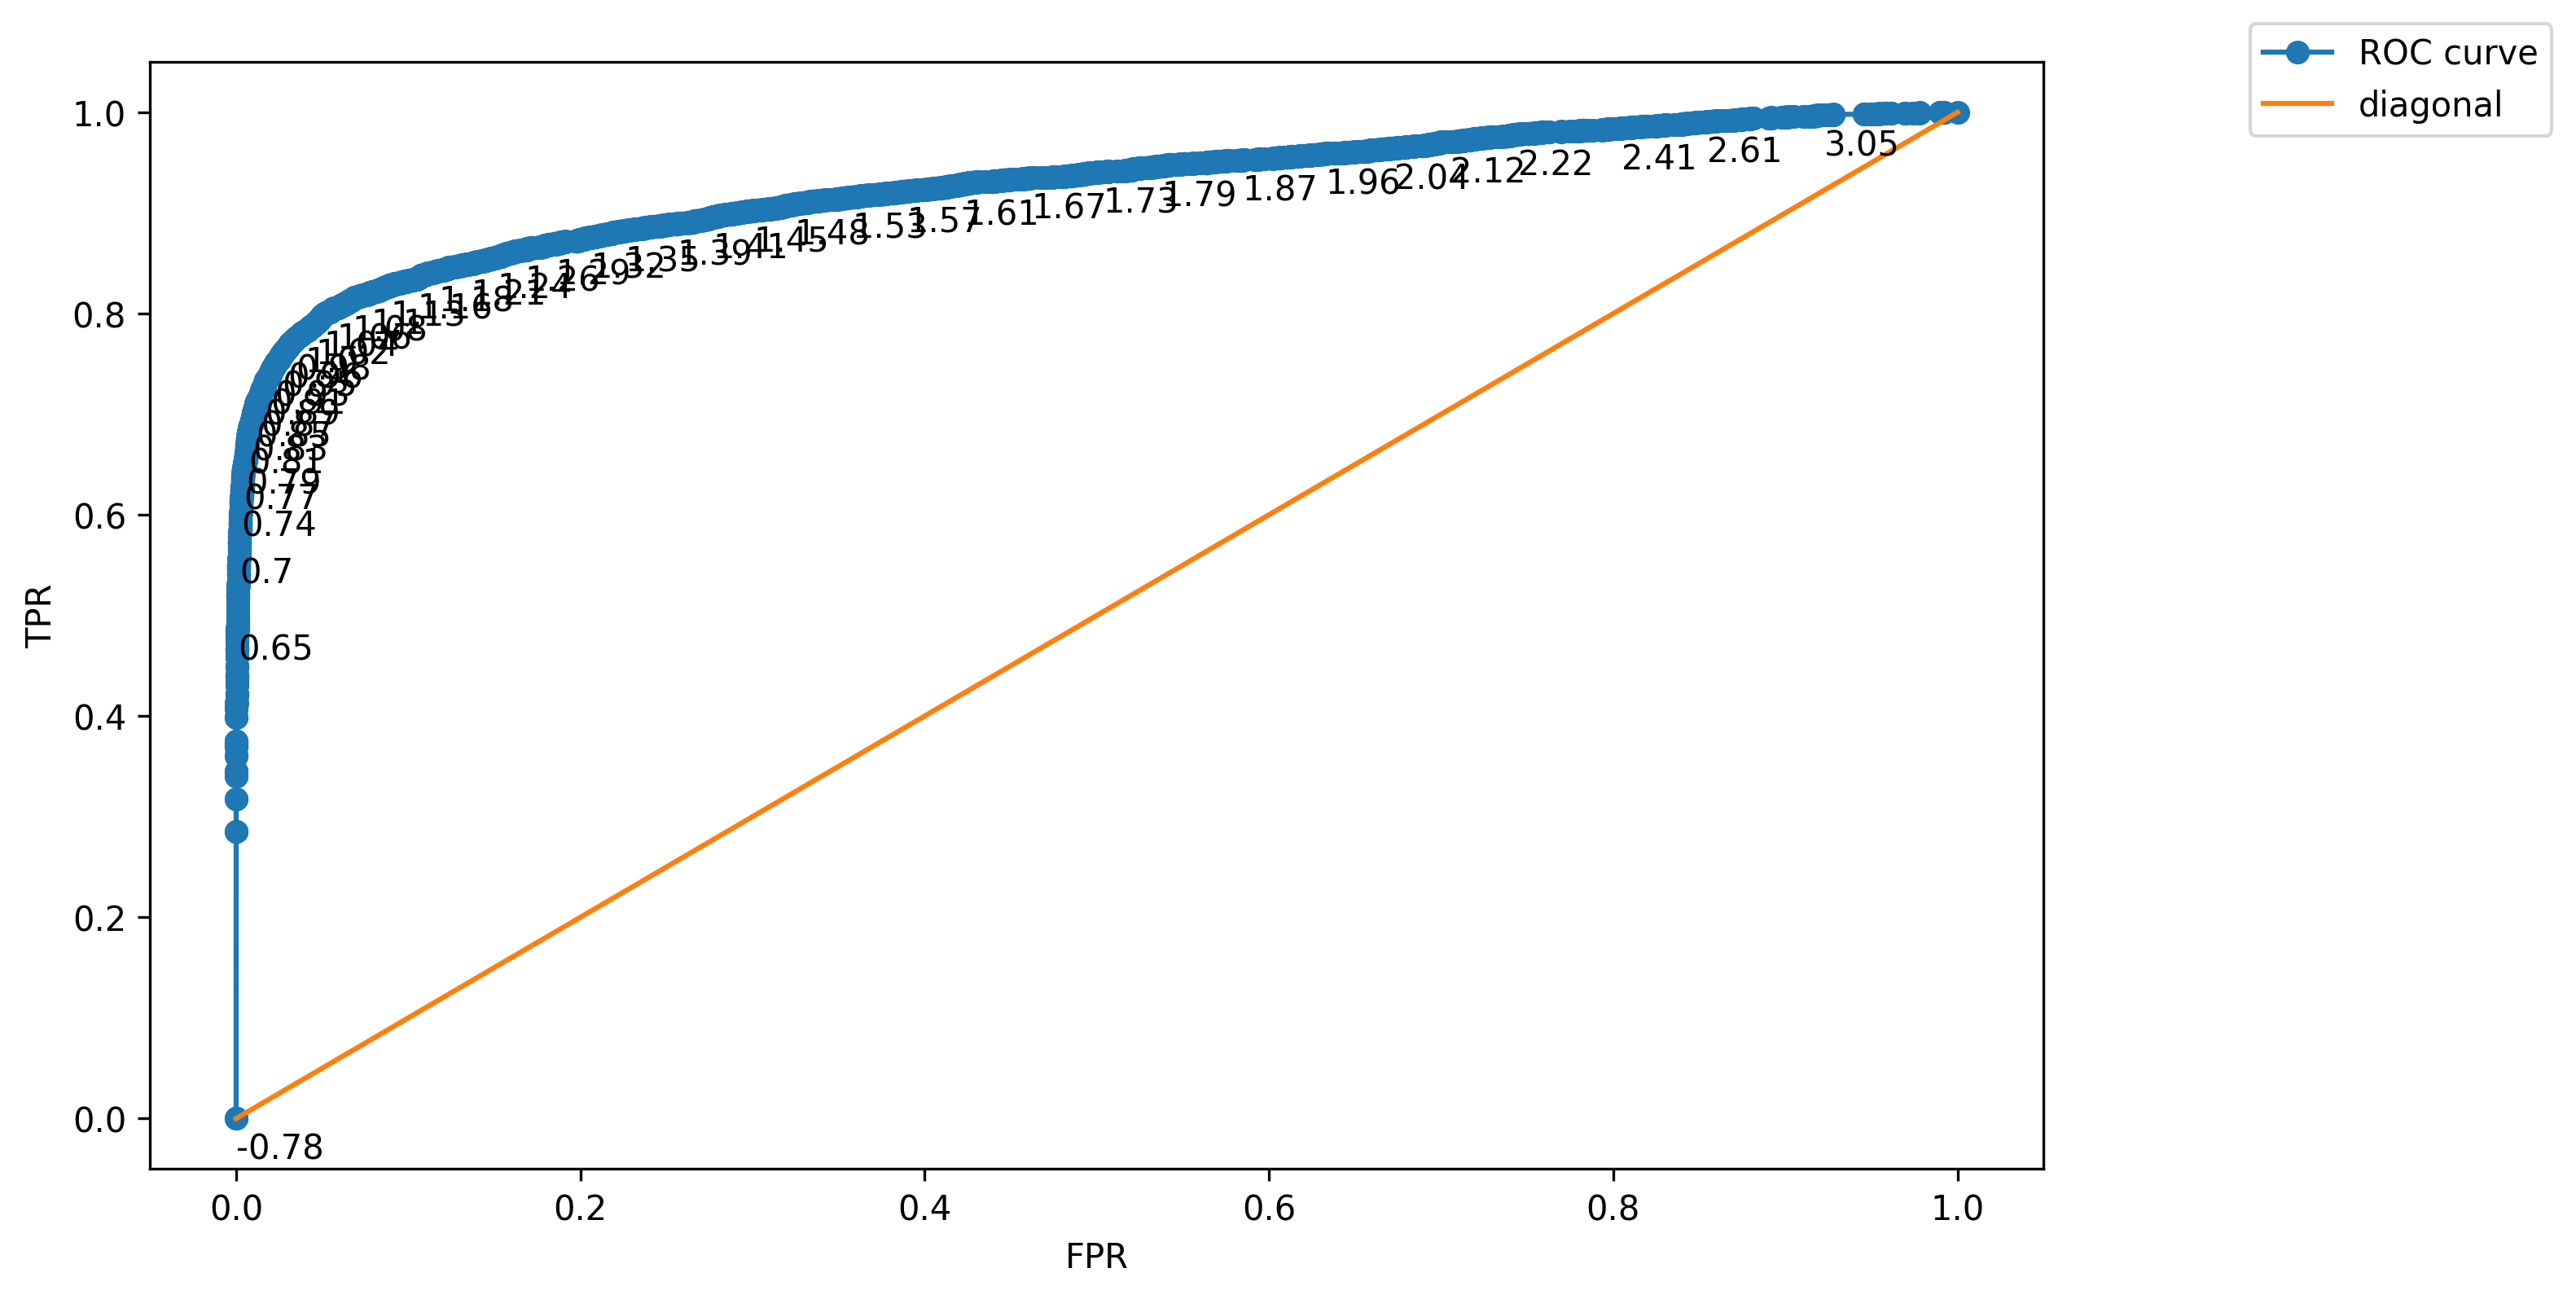

In [24]:
plot_aucroc_curve(test_pairs.IsAPair, test_pairs[METRICKEY], nth=75, is_dist=ISDIST)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.gcf().savefig(make_file_name("test-aucroc.png"))

In [25]:
test_pairs.to_csv(make_file_name("test-results.csv"))

## On Voicu !

In [26]:
import regex as re
import json
import unicodedata

df = pd.read_csv("pc-features.csv")
DFW = DataframeWrapper(df, label=("author", "title"), target="title", 
                       x_ignore=[col for col in df.columns if col not in data.features])
#
print(len(DFW.features))
print(len(data.features))
DFW.update_features(data.features)
assign_normalization(DFW)
#DFW._features = data.features
print(len(data.features))
print(len(DFW.features))

2059
2100
2100 new features found, setting them as 0.
2100
2100


In [27]:
models.eval()
pairs = get_df_prediction(
    trainer, model=models, 
    compared=DFW,
    threshold=MAX_DISTANCE
)
pairs = pairs[pairs.ComparedLabel != pairs.ComparatorLabel]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [28]:
pairs["ComparedClass"] = pairs.ComparedLabel.apply(lambda x: x.split()[0].strip())
pairs["ComparatorClass"] = pairs.ComparatorLabel.apply(lambda x: x.split()[0].strip())
pairs["IsAPair"] = pairs.ComparedClass == pairs.ComparatorClass
pairs.head()

ComparedClass                               ComparedLabel ComparatorClass  \
0          PC20  PC20 - InIlludCredidiPropterQuodLocutusSum            PC13   
1          PC20  PC20 - InIlludCredidiPropterQuodLocutusSum             PCX   
2          PC20  PC20 - InIlludCredidiPropterQuodLocutusSum             PC6   
3          PC20  PC20 - InIlludCredidiPropterQuodLocutusSum            PC16   
4          PC20  PC20 - InIlludCredidiPropterQuodLocutusSum             PC8   

                           ComparatorLabel  Distance  Probability  \
0               PC13 - InVenerabilemCrucem  1.390175    -0.390175   
1                   PCX - DeJenunioSermo5B  3.080234    -2.080234   
2               PC6 - DePoenintentiaSermo1  0.975881     0.024119   
3  PC16 - InIlludSiQuaChristoaNovaCreatura  1.577635    -0.577635   
4                  PC8 - DePatientiaSermo1  1.390935    -0.390935   

   Attribution  IsAPair  K  
0         True    False  0  
1         True    False  0  
2         True    False  0  
3         True    False  0  
4         True    False  0

In [29]:
pairs[f"Rounded{METRICKEY}"] = pairs[METRICKEY].round(3)
dists = sorted(pairs[f"Rounded{METRICKEY}"].unique())

pairs["TestTPR"] = .0
pairs["TestPre"] = .0
pairs["TestFPR"] = 1.0
pairs["TestFP"] = -1
pairs["TestFN"] = -1
pairs["TestTP"] = -1
pairs["TestTN"] = -1
pairs["DevTPR"] = .0
pairs["DevPre"] = .0
pairs["DevFPR"] = 1.0
pairs["DevFP"] = -1
pairs["DevFN"] = -1
pairs["DevTP"] = -1
pairs["DevTN"] = -1

for dist in dists:
    tp, fp, tn, fn = get_scores(test_pairs, dist, col=METRICKEY, noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs[f"Rounded{METRICKEY}"] == dist
    pairs.loc[filt, "TestTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "TestFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "TestPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "TestFP"] = fp
    pairs.loc[filt, "TestTP"] = tp
    pairs.loc[filt, "TestFN"] = fn
    pairs.loc[filt, "TestTN"] = tn
    
    # DEV
    
    tp, fp, tn, fn = get_scores(dev_pairs, dist, col=METRICKEY, noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs[f"Rounded{METRICKEY}"] == dist
    pairs.loc[filt, "DevTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "DevFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "DevPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "DevFP"] = fp
    pairs.loc[filt, "DevTP"] = tp
    pairs.loc[filt, "DevFN"] = fn
    pairs.loc[filt, "DevTN"] = tn
    

In [30]:
pairs.sort_values("DevPre").tail()

ComparedClass                            ComparedLabel ComparatorClass  \
4018           PC1                 PC1 - InGenesimSermones1            PC16   
681            PC7                     PC7 - DeIeiunoSermo7             PC7   
308           PC16  PC16 - InIlludSiQuaChristoaNovaCreatura            PC16   
3171           PC7                     PC7 - DeIeiunoSermo5             PC7   
2620           PC8                  PC8 - DePatientiaSermo1             PC6   

                          ComparatorLabel  Distance  Probability  Attribution  \
4018           PC16 - InPsalmum50Homilia1  0.276405     0.723595         True   
681                  PC7 - DeIeiunoSermo6  0.371618     0.628382         True   
308   PC16 - InIlludSufficitTibiGratiaMea  0.336637     0.663363         True   
3171                 PC7 - DeIeiunoSermo2  0.348860     0.651140         True   
2620           PC6 - DePoenintentiaSermo1  0.369619     0.630381         True   

      IsAPair  K  RoundedDistance  ...  TestFN  TestTP  TestTN    DevTPR  \
4018    False  0            0.276  ...    5630      22   40788  0.001709   
681      True  0            0.372  ...    5401     251   40788  0.030417   
308      True  0            0.337  ...    5518     134   40788  0.014354   
3171     True  0            0.349  ...    5488     164   40788  0.019481   
2620    False  0            0.370  ...    5410     242   40788  0.029050   

      DevPre  DevFPR  DevFP  DevFN  DevTP  DevTN  
4018     1.0     0.0      0   2921      5  27176  
681      1.0     0.0      0   2837     89  27176  
308      1.0     0.0      0   2884     42  27176  
3171     1.0     0.0      0   2869     57  27176  
2620     1.0     0.0      0   2841     85  27176  

[5 rows x 24 columns]

In [31]:
pairs.sort_values(["DevPre", "TestPre", "Distance"]).to_csv(make_file_name("pairs-last-experiment.csv"))

## Visualize dev

In [32]:
from freestyl.supervised.siamese.features.data import make_dataloader
import torch


trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)

# We first get the wonderful classes of compared
dev_vectors, _ = zip(
    *trainer.predict(models, make_dataloader(data_dev, model=models, batch_size=8))
)
dev_vectors = torch.cat([vec.cpu() for vec in dev_vectors], dim=0)
dataframe = []
for label, author, vector in zip(data_dev.get_labels(), data_dev.ys.tolist(), dev_vectors.tolist()):
    dataframe.append((author, label.split(" - ")[1], *vector))
    
df = pd.DataFrame(dataframe, columns=["Author", "Title", *[f"Dim{i}" for i in range(len(vector))]])

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [33]:
from umap import UMAP
import plotly.express as px


umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.loc[:, "Dim0":])

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.Author,
    labels={'color': 'Author'},
    hover_name=df.Title,
    #hover_data=["Author", "Title"]
)

fig_2d.show()
fig_2d.write_html(make_file_name("dev.html"))

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/uma

## Test

In [34]:
from freestyl.supervised.siamese.features.data import make_dataloader
import torch


trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
# We first get the wonderful classes of compared
test_vectors, _ = zip(
    *trainer.predict(models, make_dataloader(data_test, model=models, batch_size=8))
)
test_vectors = torch.cat([vec.cpu() for vec in test_vectors], dim=0)
dataframe = []
for label, author, vector in zip(data_test.get_labels(), data_test.ys.tolist(), test_vectors.tolist()):
    dataframe.append((author, label.split(" - ")[1], *vector))
df = pd.DataFrame(dataframe, columns=["Author", "Title", *[f"Dim{i}" for i in range(len(vector))]])

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning:

Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

In [35]:
from umap import UMAP
import plotly.express as px


umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.loc[:, "Dim0":])

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.Author,
    labels={'color': 'Author'},
    hover_name=df.Title,
    #hover_data=["Author", "Title"]
)

fig_2d.show()
fig_2d.write_html(make_file_name("test.html"))

## PCs

In [38]:
from freestyl.supervised.siamese.features.data import make_dataloader
import torch


trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
# We first get the wonderful classes of compared
pcs, _ = zip(
    *trainer.predict(models, make_dataloader(DFW, model=models, batch_size=8))
)
pcs = torch.cat([vec.cpu() for vec in pcs], dim=0)


dataframe = []

for label, vector in zip(DFW.get_labels(), pcs.tolist()):
    author, label = label.split(" - ")
    dataframe.append((author, label, *vector))
    
df = pd.DataFrame(dataframe, columns=["Author", "Title", *[f"Dim{i}" for i in range(len(vector))]])
df

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning:

Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

Author                                       Title      Dim0      Dim1  \
0    PC20         InIlludCredidiPropterQuodLocutusSum -0.065324 -0.170476   
1    PC13                         InVenerabilemCrucem -0.300518 -0.175331   
2     PCX                            DeJenunioSermo5B -0.322495 -0.050449   
3     PC6                        DePoenintentiaSermo1 -0.263828 -0.072876   
4    PC16            InIlludSiQuaChristoaNovaCreatura -0.135404 -0.254594   
..    ...                                         ...       ...       ...   
65  PC20b  InIlludSimileEstRegnumCaelorumGranoSinapis -0.155875 -0.240826   
66   PC10                               DePrecatione1 -0.291087  0.039641   
67    PC3                                InMeretricem -0.233590 -0.176770   
68    PC4                           InPaschaSermones6  0.095049  0.002525   
69    PC6                        DePoenintentiaSermo2 -0.201996 -0.257774   

        Dim2      Dim3      Dim4      Dim5      Dim6      Dim7  ...     Dim54  \
0  -0.064103  0.393083  0.230010 -0.538395  0.095770 -0.090740  ... -0.228067   
1  -0.104325 -0.058802 -0.161026 -0.429675 -0.242388 -0.213543  ... -0.248575   
2   0.001952 -0.233394 -0.334839 -0.101225 -0.158735 -0.311066  ... -0.339490   
3  -0.289988  0.184919 -0.316736 -0.324665 -0.193774  0.039027  ... -0.122042   
4  -0.548910  0.074332 -0.135004 -0.339223 -0.212697  0.208772  ... -0.774271   
..       ...       ...       ...       ...       ...       ...  ...       ...   
65  0.090030  0.455463 -0.149345 -0.031335  0.325462 -0.089933  ...  0.175249   
66  0.053208 -0.014610 -0.016930 -0.755497 -0.238172  0.441278  ... -0.293850   
67 -0.463143  0.564734 -0.127662 -0.541314  0.118605 -0.000811  ... -0.289049   
68  0.147439 -0.005946 -0.022197 -0.090395  0.178371 -0.324123  ... -0.126888   
69 -0.014939 -0.002424 -0.493082 -0.379226 -0.047388 -0.134014  ... -0.288336   

       Dim55     Dim56     Dim57     Dim58     Dim59     Dim60     Dim61  \
0  -0.012879 -0.401615  0.179887  0.041978  0.173719 -0.061206  0.028059   
1   0.070377  0.036691  0.236449  0.016923  0.287783 -0.222041  0.240990   
2   0.173517  0.159012  0.226426 -0.044248  0.450295  0.367565  0.190737   
3  -0.079191 -0.184891  0.112543 -0.008284  0.273293 -0.073429  0.233524   
4   0.066770 -0.227683  0.370562  0.187854  0.093526 -0.120559 -0.064883   
..       ...       ...       ...       ...       ...       ...       ...   
65 -0.460916  0.092440 -0.086239 -0.287308  0.112343  0.216982  0.214031   
66 -0.154260 -0.001045  0.045113  0.006336  0.115531  0.167604 -0.060567   
67 -0.294675 -0.034461  0.142095 -0.351982  0.256397  0.069571  0.455979   
68 -0.062876 -0.127619  0.125983 -0.042644  0.252882  0.157142  0.380171   
69  0.120931 -0.375745  0.125900 -0.164627  0.483648  0.198283  0.370206   

       Dim62     Dim63  
0   0.085874  0.205617  
1  -0.004075 -0.021640  
2  -0.199762  0.109864  
3  -0.124759  0.137286  
4  -0.102216 -0.083780  
..       ...       ...  
65  0.267990  0.130463  
66  0.115618  0.255412  
67 -0.070430 -0.006306  
68  0.226494  0.170258  
69 -0.004936  0.252497  

[70 rows x 66 columns]

In [39]:
from umap import UMAP
import plotly.express as px


umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.loc[:, "Dim0":])

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.Author,
    labels={'color': 'Author'},
    hover_name=df.Title,
    #hover_data=["Author", "Title"]
)

fig_2d.show()
fig_2d.write_html(make_file_name("pc.html"))